# Model of Nucleosome Positioning

This notebook demonstrates the full analysis of the nucleosome positioning model. This notebook is used to check my work.

### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Initialize Nucleosome Array.

##### Utility Functions

In [2]:
def gen_meth(n_n, f_m, l_m=0):
    """Generate methylation profile with mean and correlation.

    Parameters:
    n_n (int) number of nucleosomes,
    f_m (float) probability that a tail is methylated,
    l_m (float) correlation length in methylation

    Returns:
    n_m (np.ndarray of int) number of methylated tails per nucleosome
    """
    # Compute methylation probabilities
    if l_m == 0:
        lam = 0.
    else:
        lam = np.exp(-1 / l_m)
    f_u = 1 - f_m
    p_mm = lam * f_u + f_m  # P(methylated | methylated at previous site)
    p_uu = lam * f_m + f_u  # P(unmethylated | unmethylated at previous site)
    prob_tot = [(1 - f_m) ** 2, 2 * f_m * (1 - f_m), f_m ** 2]
    prob_m = [2 * (1 - f_m) / (2 - f_m), f_m / (2 - f_m)]

    # Generate the methylation profile
    n_m = np.zeros(n_n)
    n_m[0] = np.random.choice([0, 1, 2], 1, p=prob_tot)
    for i_n in range(1, n_n):
        if n_m[i_n - 1] == 0:
            if np.random.uniform(0, 1) < p_uu:
                n_m[i_n] = 0
            else:
                n_m[i_n] = np.random.choice([1, 2], 1, p=prob_m)
        else:
            if np.random.uniform(0, 1) < p_mm:
                n_m[i_n] = np.random.choice([1, 2], 1, p=prob_m)
            else:
                n_m[i_n] = 0
    return n_m

##### Application

In [3]:
num_nucleosomes = 1000
frac_methylated = 0.26
correlation_length = 18.4
methyl_pattern = gen_meth(
    num_nucleosomes, frac_methylated, correlation_length
)

### 2. Model Cooperative HP1 Binding.

##### Utility Functions

In [4]:
def get_single_nucleosome_energy(s_i, sigma_i, mu, epsilon_m, J_int):
    """Compute the free energy associated with a single nucleosome.
    
    Parameters:
    s_i (int) mark state (0, 1, 2) of nucleosome i,
    sigma_i (int) binding state (0, 1, 2) of nucleosome i,
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    J_int (float) interaction energy
    
    Returns:
    (float) free energy associated with a single nucleosome
    """
    if sigma_i == 0:
        return 0
    elif sigma_i == 1:
        if s_i == 0:
            return -mu - np.log(2)
        elif s_i == 1:
            return -mu - np.log(1 + np.exp(-epsilon_m))
        else:
            return -mu + epsilon_m - np.log(2)
    else:
        return -2 * mu + s_i * epsilon_m + J_int
    
    
def get_inter_nucleosomal_energy(sigma_i, sigma_ip1, gamma_i, J_int):
    """Get the free energy associated with neighboring nucleosomes.
    
    Parameters:
    sigma_i (int) binding state (0, 1, 2) of nucleosome i,
    sigma_ip1 (int) binding state (0, 1, 2) of nucleosome i+1,
    gamma_i (int) indicator of linker_i <= 15 bp (1) or > 15 bp (0),
    J_int (float) interaction energy
    
    Returns:
    (float) free energy associated with neighboring nucleosomes
    """
    return J_int * gamma_i * sigma_i * sigma_ip1


def construct_transfer_matrix(
    s_i, s_ip1, mu, epsilon_m, gamma_i, J_int
):
    """Generate the 2-by-2 transfer matrix for neighboring nucleosomes.
    
    Parameters:
    s_i (int) mark state (0, 1, 2) of nucleosome i,
    s_ip1 (int) mark state (0, 1, 2) of nucleosome i+1,
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    gamma_i (int) indicator of linker_i <= 15 bp (1) or > 15 bp (0),
    J_int (float) interaction energy
    
    Returns:
    T (2-by-2 np.ndarray of float) transfer matrix
    """
    T = np.zeros((3, 3))
    for sigma_i in range(3):
        for sigma_ip1 in range(3):
            T[sigma_i, sigma_ip1] = np.exp(
                - get_single_nucleosome_energy(
                    s_i, sigma_i, mu, epsilon_m, J_int
                ) / 2 - get_single_nucleosome_energy(
                    s_ip1, sigma_ip1, mu, epsilon_m, J_int
                ) / 2 - get_inter_nucleosomal_energy(
                    sigma_i, sigma_ip1, gamma_i, J_int
                )
            )
    return T


def get_all_transfer_matrices(
    methyl_pattern, mu, epsilon_m, J_int, gamma
):
    """Construct all transfer matrices.
    
    Parameters:
    methyl_pattern (np.ndarray of int) mark pattern for full chain,
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    J_int (float) interaction energy,
    gamma (np.array of int) indicators of linker_i <= 15 bp (1) or
        > 15 bp (0) for all i
    
    Returns:
    (list of np.ndarray) Transfer matrices for all nucleosome pairs
    """
    num_nucleosomes = len(methyl_pattern)
    transfer_matrices = []
    for i in range(num_nucleosomes):
        s_i = methyl_pattern[i]
        gamma_i = gamma[i]
        if i == (num_nucleosomes - 1):
            s_ip1 = methyl_pattern[0]
        else:
            s_ip1 = methyl_pattern[i+1]
        T = construct_transfer_matrix(
            s_i, s_ip1, mu, epsilon_m, gamma_i, J_int
        )
        transfer_matrices.append(T)
    return transfer_matrices


def evaluate_partition_function(transfer_matrices):
    """Evaluate the partition function by the transfer-matrix method.
    
    Parameters:
    transfer_matrices (list of np.ndarray) Transfer matrices for all
        neighboring nucleosome pairs
        
    Returns:
    (float) Solution to partition function
    factors (list of float) Normalization factors enabling numerical
        stability during matrix multiplication
    """
    mat_prod = transfer_matrices[0]
    factors = []
    
    for i in range(1, len(transfer_matrices)):
        mat_prod = np.matmul(mat_prod, transfer_matrices[i])
        factor = np.average(mat_prod)
        factors.append(factor)
        mat_prod /= factor

    return np.trace(mat_prod), factors


def compute_total_free_energy(transfer_matrices):
    """Compute the total free energy of a configuration.
    
    Parameters:
    transfer_matrices (list of np.ndarray) Transfer matrices for all
        neighboring nucleosome pairs
        
    Returns:
    (float) Total free energy
    """
    part_fxn, factors = evaluate_partition_function(transfer_matrices)
    return - np.log(part_fxn) - np.sum(np.log(factors))

##### Application

In [5]:
mu = -9.8
epsilon_m = -1.5
J_int = -3.92

### 3. Sample Linker Lengths.

##### Utility Functions

In [6]:
def get_free_energy_difference(
    methyl_pattern, gamma, i, mu, epsilon_m, J_int
):
    """Get difference in free energy for gamma_i = 1 and gamma_i = 0.
    
    Parameters:
    methyl_pattern (np.ndarray of int) mark pattern for full chain,
    gamma (np.array of int) indicators of linker_i <= 15 bp (1) or
        > 15 bp (0) for all i
    i (int) linker identifier
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    J_int (float) interaction energy,
    
    Returns:
    delta_F (float) Difference in free energy between gamma_i = 1 and
        gamma_i = 0
    """
    # Generate alternative gamma patterns
    gamma_1 = gamma.copy()
    gamma_0 = gamma.copy()
    gamma_1[i] = 1    
    gamma_0[i] = 0
    
    # Construct transfer matrices
    T_1 = get_all_transfer_matrices(
        methyl_pattern, mu, epsilon_m, J_int, gamma_1
    )
    T_0 = get_all_transfer_matrices(
        methyl_pattern, mu, epsilon_m, J_int, gamma_0
    )
    
    # Compute free energies
    F_1 = compute_total_free_energy(T_1)
    F_0 = compute_total_free_energy(T_0)
    
    return F_1 - F_0


def get_P_gt(
    methyl_pattern, gamma, i, mu, epsilon_m, J_int
):
    """Get the probability of having gamma_i = 1.
    
    Parameters:
    methyl_pattern (np.ndarray of int) mark pattern for full chain,
    gamma (np.array of int) indicators of linker_i <= 15 bp (1) or
        > 15 bp (0) for all i
    i (int) linker identifier,
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    J_int (float) interaction energy
    
    Returns:
    delta_F (float) Difference in free energy between gamma_i = 1 and
        gamma_i = 0,
    P_gt (float) Probability that gamma_i = 1
    """
    delta_F = get_free_energy_difference(
        methyl_pattern, gamma, i, mu, epsilon_m, J_int
    )
    if delta_F < 0:
        P_gt = 1
    else:
        P_gt = np.exp(-delta_F)
    return delta_F, P_gt
    

l_0 = 45  # Average linker length (in bp)
l_c = 15  # Cutoff linker length for HP1 interactions (in bp)
lam = -np.log(1 - 1/l_0)
z = np.exp(-lam)

short_linkers = np.arange(1, 15 + 1)
long_linkers = np.arange(16, 5000 + 1)
all_linkers = np.concatenate([short_linkers, long_linkers])
all_linkers = all_linkers.astype(int)
    

def sample_linker_length(i, delta_F):
    """Sample a new length for linker i.
    
    Parameters:
    i (int) linker identifier,
    delta_F (float) Difference in free energy between gamma_i = 1 and
        gamma_i = 0
    
    Returns:
    linker (int) New linker length (in bp)
    gamma_i (int) indicators of linker <= 15 bp (1) or > 15 bp (0)
    """
    # Compute probabilities of all linker lengths
    norm = z / (1 - z) * ((1 - z**l_c) * np.exp(-delta_F) + z**l_c)
    P_short = 1 / norm * np.exp(-lam * short_linkers) * np.exp(-delta_F)
    P_long = 1 / norm * np.exp(-lam * long_linkers)
    P_all = np.concatenate([P_short, P_long])
    
    # Adjust for rounding errors
    tot_prob = np.sum(P_all)
    assert np.isclose(tot_prob, 1), \
        f"Probabilities do not sum to 1. They sum to {round(tot_prob, 2)}."
    P_all = P_all / tot_prob
    
    # Select linker length
    linker = np.random.choice(all_linkers, p = P_all)
    gamma_i = int(linker <= 15)
    return linker, gamma_i


def mc_sim(methyl_pattern, n_steps, mu, epsilon_m, J_int):
    """Sample linker lengths by Monte Carlo simulation.
    
    Parameters:
    methyl_pattern (np.ndarray of int) mark pattern for full chain,
    n_steps (int) number of sampling iterations,
    mu (float) chemical potential of HP1,
    epsilon_m (float) energy of binding a marked site,
    J_int (float) interaction energy
    
    Returns:
    links (np.ndarray) equilibrated linker length pattern
    """
    # Initialize linker lengths
    num_nucleosomes = len(methyl_pattern)
    links = np.ones(num_nucleosomes, dtype=int)
    gamma = np.ones(num_nucleosomes, dtype=int)
    
    for step in range(n_steps):

        # Print an update
        if (step + 1) % 50 == 0:
            print(f"step {step + 1} of {n_steps}")
        
        # Sample random linker index
        ind = np.random.randint(num_nucleosomes)
    
        # Get the energy difference
        delta_F = get_free_energy_difference(
            methyl_pattern, gamma, ind, mu, epsilon_m, J_int
        )
        
        # Sample a new linker length
        link_ind, gamma_ind = sample_linker_length(ind, delta_F)
        
        # Update linker length profile
        links[ind] = link_ind
        gamma[ind] = gamma_ind
    
    return links

##### Application

In [7]:
# Generate correlated H3K9me3 pattern with 12-14% of tails marked
while True:
    methyl_pattern = gen_meth(
        num_nucleosomes, frac_methylated, correlation_length
    )
    true_frac_methyl = np.average(methyl_pattern) / 2
    if 0.08 <= true_frac_methyl <= 0.10:
        break

In [8]:
# Run a MC simulation
n_steps = 20000
save_file = "example_links_0p09_v2.csv"
if not os.path.exists(save_file):
    links = mc_sim(methyl_pattern, n_steps, mu, epsilon_m, J_int)
else:
    print("Simulation already exists.")
    print(
        f"Delete {save_file} and rerun this code block to "
        "rerun the simulation."
    )

step 50 of 20000
step 100 of 20000
step 150 of 20000
step 200 of 20000
step 250 of 20000
step 300 of 20000
step 350 of 20000
step 400 of 20000
step 450 of 20000
step 500 of 20000
step 550 of 20000
step 600 of 20000
step 650 of 20000
step 700 of 20000
step 750 of 20000
step 800 of 20000
step 850 of 20000
step 900 of 20000
step 950 of 20000
step 1000 of 20000
step 1050 of 20000
step 1100 of 20000
step 1150 of 20000
step 1200 of 20000
step 1250 of 20000
step 1300 of 20000
step 1350 of 20000
step 1400 of 20000
step 1450 of 20000
step 1500 of 20000
step 1550 of 20000
step 1600 of 20000
step 1650 of 20000
step 1700 of 20000
step 1750 of 20000
step 1800 of 20000
step 1850 of 20000
step 1900 of 20000
step 1950 of 20000
step 2000 of 20000
step 2050 of 20000
step 2100 of 20000
step 2150 of 20000
step 2200 of 20000
step 2250 of 20000
step 2300 of 20000
step 2350 of 20000
step 2400 of 20000
step 2450 of 20000
step 2500 of 20000
step 2550 of 20000
step 2600 of 20000
step 2650 of 20000
step 2700 of 

In [9]:
if not os.path.exists(save_file):
    np.savetxt(save_file, links)

In [10]:
links = np.loadtxt(save_file)

In [11]:
links = links.astype(int)
print("Linker Lengths:\n")
print(links)

Linker Lengths:

[ 18   6  14   2   2   2  11   8  10   3  12   3   9   5  12  13   5   3
   1   6   3   2  10  11  15  11   5   1  13   2   3   3  12   5   3  13
  15  12   7   2   8   7  10   3   7   1   5  12   3  10  14   8   5  12
   5   3   9   8   3   8   2   5   9   2  15   4   1  15   1  13   3   7
  13  10   9   2  15   1   7   7   6  14  13   3   8  39 137  73  75   6
  35  84  63  36  35  13  41  12  46  69  49  14  16  96   3  24 184  24
  57  35   3  24  15   1  14  30  84 102  25  34  60   6  71  81  69  12
   5  16  26  68  29   7   7  81   8   1  24  55   8  57  36  25  81   1
  43  11  46  66  53  27 112  71  31  34   4  27 156  11  19   4  40 147
   7 121  50  72 112  32  69 109  80 199  27  29  20  79   7  56   6  11
  13   4   3 103  97  14  54  64 101 104  51  19 139  64   1  73  17  68
 157  48   2  85  53 141  31  52  20  18  44  61  44  34   4   7   9   1
  14   5  18  82  16   7  32 173  59  44  12   4   6   5  65  46  62  39
  77  26  28   4  26 136  25  15  

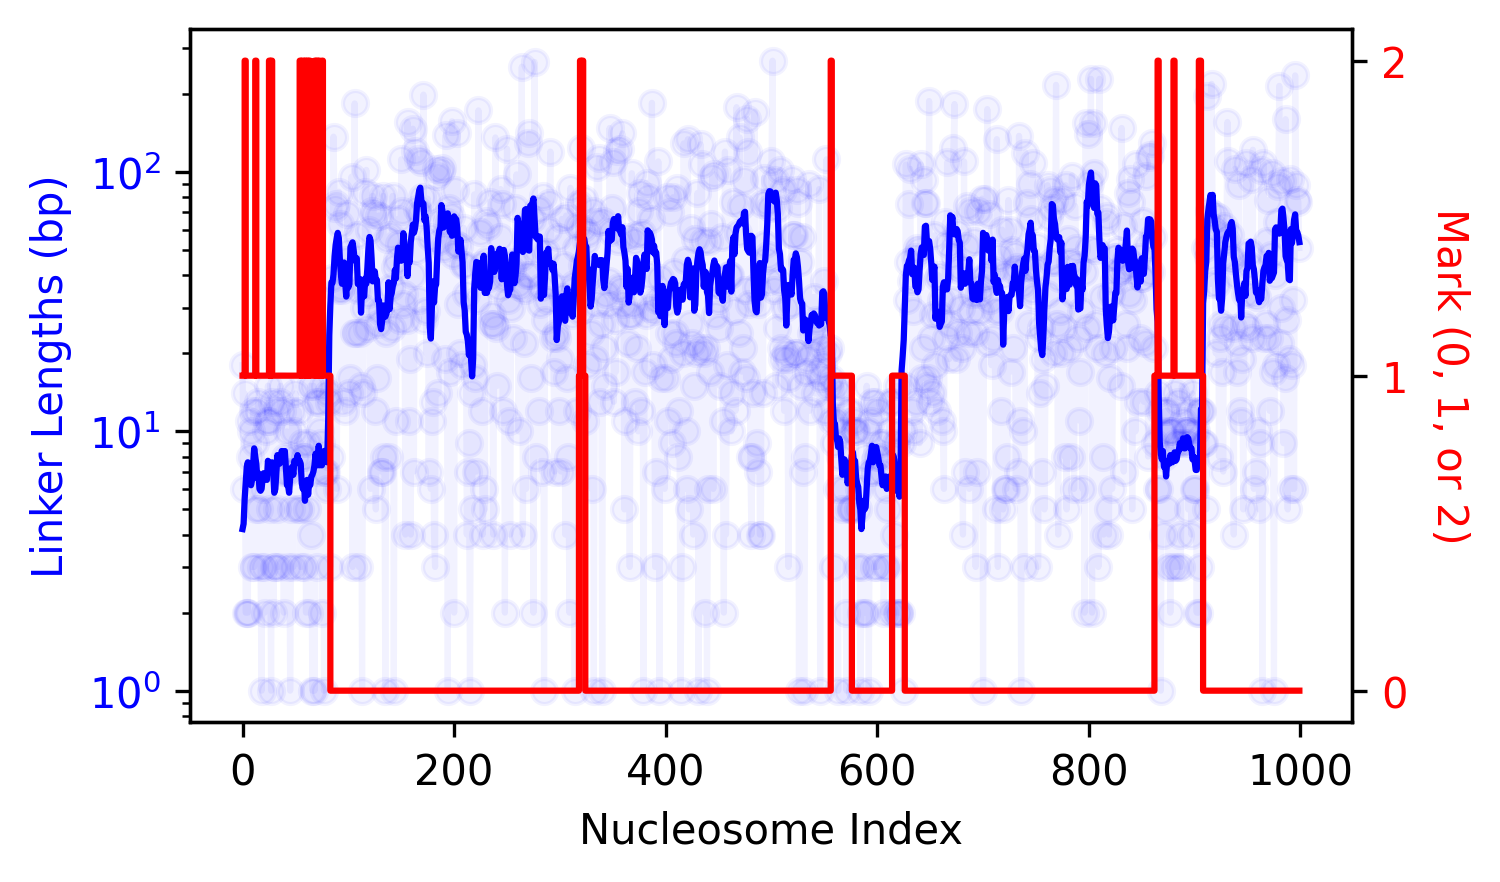

In [12]:
window_size = 10
moving_avg_links = np.convolve(
    links, np.ones(window_size)/window_size, mode='same'
)
nucleosome_indices = np.arange(len(links))

fig, ax1 = plt.subplots(figsize=(5,3), dpi=300)

ax1.plot(nucleosome_indices, links, "o-", color='blue', alpha=0.05)
ax1.plot(nucleosome_indices, moving_avg_links, "-", color='blue', label='Linker Lengths (bp)')
ax1.set_xlabel('Nucleosome Index')
ax1.set_ylabel('Linker Lengths (bp)', color='blue')
ax1.set_yscale('log')  # Set y-axis to log scale
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.step(nucleosome_indices, methyl_pattern, "-", color='red', label='Mark (0, 1, or 2)')
ax2.set_ylabel('Mark (0, 1, or 2)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_yticks([0, 1, 2])
ax2.yaxis.get_label().set_rotation(270)
ax2.yaxis.labelpad = 15

plt.show()

### 4. Construct 3D Configuration.

##### Utility Functions

The code in the following codeblock is gathered from [wlcstat](https://ajspakow.github.io/wlcstat/_modules/wlcstat/chromo.html).

In [13]:
# Constants for bare DNA properties
naked_dna_length_per_base = 0.332               # length of DNA per base pair (nm)
default_lt = 100 / naked_dna_length_per_base    # twist persistance length of DNA in bp: 100 nm, or ~301 bp
default_lp = 50 / naked_dna_length_per_base     # bend persistance length of DNA in bp: 50 nm, or ~150 bp
default_w_in = 73                               # number of bound base pairs in the entry side of dyad axis base in bp
default_w_out = 73                              # number of bound base pairs in the exit side of dyad axis base in bp
default_Lw = default_w_in + default_w_out
naked_dna_twist_density = 10.5
naked_dna_length_per_base = 0.332
naked_dna_thickness = 2.0
nucleosome_bound_dna_twist_density = 10.17
dna_params = {'tau_n': 2 * np.pi / nucleosome_bound_dna_twist_density,
              'tau_d': 2 * np.pi / naked_dna_twist_density,
              'lpb': naked_dna_length_per_base,
              'r_dna': naked_dna_thickness / 2}
helix_params_reported_richmond_davey_2003 = {
        'T': 1.67, 'b': 133.6, 'c': 41.181, 'r': 41.9,
        'phi': 0, 'psi0': 0, 'theta': 0, 'x0': 0, 'y0': 0, 'z0': 0}

helix_params_best = {'r': 4.1899999999999995, 'c': 4.531142964071856, 'T': 1.8375, 'b': 147}


def resolve_wrapping_params(unwraps, w_ins=None, w_outs=None, N=None, unwrap_is='bp'):
    """Allow the user to specify either one value (and tile appropriately) or
    an array of values for the number of base pairs bound to the nucleosome.
    Also allow either the number of base pairs bound on each side of the dyad to be
    specified or the number of base pairs unwrapped relative to the crystal
    structure (in which case the unwrapping is split evenly on either side of
    the dyad for simplicity.

    Parameters
    ----------
    unwraps : float or (N,) array_like
        total amount of unwrapped DNA on both sides
    w_ins (optional): float or (N,) array_like
        wrapped DNA on entry side of dyad axis
    w_outs (optional): float or (N,) array_like
        wrapped DNA on exit side of dyad axis
    N (optional): int
        output size, if other params are not array_like
    unwrap_is : string
        'bp' or 'sites', to specify whether we're counting the number of bp
        bound or the number of nucleosome-to-dna contacts (respectively)

    Returns
    -------
    w_in : (N,) np.ndarray
        N output wrapping lengths on entry side of dyad axis
    w_out : (N,) np.ndarray
        N output wrapping lengths on exit side of dyad axis

    All functions take w_in, w_out directly now."""
    if (w_ins is None) != (w_outs is None):
        raise ValueError("Either none or both of w_in and w_out must be specified.")

    if unwraps is not None:
        unwraps = np.atleast_1d(unwraps)
        w_ins, w_outs = zip(*map(functools.partial(resolve_unwrap, unwrap_is=unwrap_is), unwraps))
    w_ins = np.atleast_1d(w_ins)
    w_outs = np.atleast_1d(w_outs)
    if len(w_ins) == 1 and N is not None:
        w_ins = np.tile(w_ins, (N,))
        w_outs = np.tile(w_outs, (N,))
    return w_ins, w_outs


def gen_chromo_conf(
    links, lt=default_lt, lp=default_lp, kd_unwrap=None,
    w_ins=default_w_in, w_outs=default_w_out,
    tau_d=dna_params['tau_d'], tau_n=dna_params['tau_n'],
    lpb=dna_params['lpb'], r_dna=dna_params['r_dna'],
    helix_params=helix_params_best, unwraps=None,
    random_phi=False
):
    """Generate DNA and nucleosome conformation based on chain growth algorithm.
    """
    # Put the parameters into an appropriate form
    nbpnuc = helix_params['b']
    num_linkers = len(links)
    num_nuc = num_linkers + 1
    hnuc = helix_params['c'] / 2
    rnuc = helix_params['r']
    ltnuc = np.sqrt(hnuc ** 2 + (2 * np.pi * rnuc) ** 2)
    eps = lp / lpb
    epst = lt / lpb
    om = tau_d
    omnuc = tau_n
    omdna = 0.75 * np.pi

    # resolve kd_unwrap
    if kd_unwrap is not None:
        sites_unbound_left = scipy.stats.binom(7, kd_unwrap).rvs(num_nuc)
        sites_unbound_right = scipy.stats.binom(7, kd_unwrap).rvs(num_nuc)
        w_ins, w_outs = resolve_wrapping_params(sites_unbound_left + sites_unbound_right,
                w_ins, w_outs, num_nucleosomes, unwrap_is='sites')
    else:
        w_ins, w_outs = resolve_wrapping_params(unwraps, w_ins, w_outs, num_nuc)
    bounds = w_ins + w_outs + 1

    # Initialize the conformation
    num_bp_total = np.sum(links) + np.sum(bounds)
    r = np.zeros((num_bp_total, 3))
    rdna1 = np.zeros((num_bp_total, 3))
    rdna2 = np.zeros((num_bp_total, 3))
    t1 = np.zeros((num_bp_total, 3))
    t2 = np.zeros((num_bp_total, 3))
    t3 = np.zeros((num_bp_total, 3))
    rn = np.zeros((num_nuc, 3))
    un = np.zeros((num_nuc, 3))

    # Generate the conformation using the chain-growth algorithm
    t10 = np.array([1, 0, 0])
    t30 = np.array([0, 0, 1])
    t20 = np.cross(t30, t10)
    r0 = np.array([0, 0, 0])

    count = 0
    for inuc in range(num_nuc):
        # Generate the nucleosomal dna
        bound = bounds[inuc]
        n1 = -t10
        n3 = (2 * np.pi * rnuc / ltnuc) * t20 + (hnuc / ltnuc) * t30
        n2 = np.cross(n3, n1)

        delta = - rnuc * n1 + (hnuc * (bound - 1) * lpb / (2 * ltnuc)) * n3
        rn[inuc, :] = r0 + delta
        un[inuc, :] = n3

        for i in range(bound):
            s = i * lpb
            r[count, :] = (rnuc * np.cos(2 * np.pi * s / ltnuc) * n1 +
                           rnuc * np.sin(2 * np.pi * s / ltnuc) * n2 +
                           (hnuc * s / ltnuc) * n3 + r0 - rnuc * n1)
            if i == 0:
                t1[count, :] = t10
                t2[count, :] = t20
                t3[count, :] = t30
            else:
                t3[count, :] = (- (2 * np.pi * rnuc / ltnuc) * np.sin(2 * np.pi * s / ltnuc) * n1
                                + (2 * np.pi * rnuc / ltnuc) * np.cos(2 * np.pi * s / ltnuc) * n2
                                + hnuc / ltnuc * n3)
                t3[count, :] /= np.linalg.norm(t3[count, :])
                th = np.arccos(np.dot(t3[count, :], t3[count - 1, :]))
                phi = np.arctan2(np.dot(t3[count, :], t2[count - 1, :]), np.dot(t3[count, :], t1[count - 1, :]))
                psi = -phi + omnuc

                t1p = (np.cos(th) * np.cos(phi) * t1[count - 1, :]
                       + np.cos(th) * np.sin(phi) * t2[count - 1, :]
                       - np.sin(th) * t3[count - 1, :])
                t1p -= np.dot(t3[count, :], t1p) * t3[count, :]
                t1p /= np.linalg.norm(t1p)
                t2p = np.cross(t3[count, :], t1p)
                t1[count, :] = np.cos(psi) * t1p + np.sin(psi) * t2p
                t2[count, :] = np.cross(t3[count, :], t1[count, :])

            rdna1[count, :] = r[count, :] + t1[count, :] * r_dna
            rdna2[count, :] = r[count, :] + r_dna * (np.cos(omdna) * t1[count, :] +
                                                     np.sin(omdna) * t2[count, :])
            count += 1

        # Calculate the position and orientation heading into the next linker

        th = np.arccos(1 / eps * np.log(
            np.random.uniform() * 2 * np.sinh(eps) + np.exp(-eps)))
        phi = 2 * np.pi * np.random.uniform()
        psi = -phi + om + np.random.normal() / np.sqrt(epst)

        t1p = (np.cos(th) * np.cos(phi) * t1[count - 1, :]
               + np.cos(th) * np.sin(phi) * t2[count - 1, :]
               - np.sin(th) * t3[count - 1, :])
        t3p = (np.sin(th) * np.cos(phi) * t1[count - 1, :]
               + np.sin(th) * np.sin(phi) * t2[count - 1, :]
               + np.cos(th) * t3[count - 1, :])
        t3p /= np.linalg.norm(t3p)
        t1p -= np.dot(t3p, t1p) * t3p
        t1p /= np.linalg.norm(t1p)
        t2p = np.cross(t3p, t1p)

        t10 = np.cos(psi) * t1p + np.sin(psi) * t2p
        t30 = t3p
        t20 = np.cross(t30, t10)
        r0 = r[count - 1, :] + t30 * lpb

        # Generate the linker dna
        if inuc < (num_nuc - 1):
            link = links[inuc]

            t1[count, :] = t10
            t2[count, :] = t20
            t3[count, :] = t30
            r[count, :] = r0
            rdna1[count, :] = r[count, :] + t1[count, :] * r_dna
            rdna2[count, :] = r[count, :] + r_dna * (np.cos(omdna) * t1[count, :] +
                                                     np.sin(omdna) * t2[count, :])
            count += 1

            for i in range(1, link):
                th = np.arccos(1 / eps * np.log(
                    np.random.uniform() * 2 * np.sinh(eps) + np.exp(-eps)))
                phi = 2 * np.pi * np.random.uniform()
                psi = -phi + om + np.random.normal() / np.sqrt(epst)

                t1p = (np.cos(th) * np.cos(phi) * t1[count - 1, :]
                       + np.cos(th) * np.sin(phi) * t2[count - 1, :]
                       - np.sin(th) * t3[count - 1, :])
                t3p = (np.sin(th) * np.cos(phi) * t1[count - 1, :]
                       + np.sin(th) * np.sin(phi) * t2[count - 1, :]
                       + np.cos(th) * t3[count - 1, :])
                t3p /= np.linalg.norm(t3p)
                t1p -= np.dot(t3p, t1p) * t3p
                t1p /= np.linalg.norm(t1p)
                t2p = np.cross(t3p, t1p)

                t1[count, :] = np.cos(psi) * t1p + np.sin(psi) * t2p
                t3[count, :] = t3p
                t2[count, :] = np.cross(t3[count, :], t1[count, :])

                r[count, :] = r[count - 1, :] + t3[count, :] * lpb
                rdna1[count, :] = r[count, :] + t1[count, :] * r_dna
                rdna2[count, :] = r[count, :] + r_dna * (np.cos(omdna) * t1[count, :] +
                                                     np.sin(omdna) * t2[count, :])
                count += 1

            # Calculate the position and orientation heading into the nucleosome
            th = np.arccos(1 / eps * np.log(
                np.random.uniform() * 2 * np.sinh(eps) + np.exp(-eps)))
            phi = 2 * np.pi * np.random.uniform()
            psi = -phi + om + np.random.normal() / np.sqrt(epst)

            t1p = (np.cos(th) * np.cos(phi) * t1[count - 1, :]
                   + np.cos(th) * np.sin(phi) * t2[count - 1, :]
                   - np.sin(th) * t3[count - 1, :])
            t3p = (np.sin(th) * np.cos(phi) * t1[count - 1, :]
                   + np.sin(th) * np.sin(phi) * t2[count - 1, :]
                   + np.cos(th) * t3[count - 1, :])
            t3p /= np.linalg.norm(t3p)
            t1p -= np.dot(t3p, t1p) * t3p
            t1p /= np.linalg.norm(t1p)
            t2p = np.cross(t3p, t1p)

            t10 = np.cos(psi) * t1p + np.sin(psi) * t2p
            t30 = t3p
            t20 = np.cross(t30, t10)

            r0 = r[count - 1, :] + t30 * lpb

    return r, rdna1, rdna2, rn, un

##### Application

In [14]:
n_realizations = 20
all_rn = []

for _ in range(n_realizations):
    _, _, _, rn, _ = gen_chromo_conf(links)
    all_rn.append(rn)

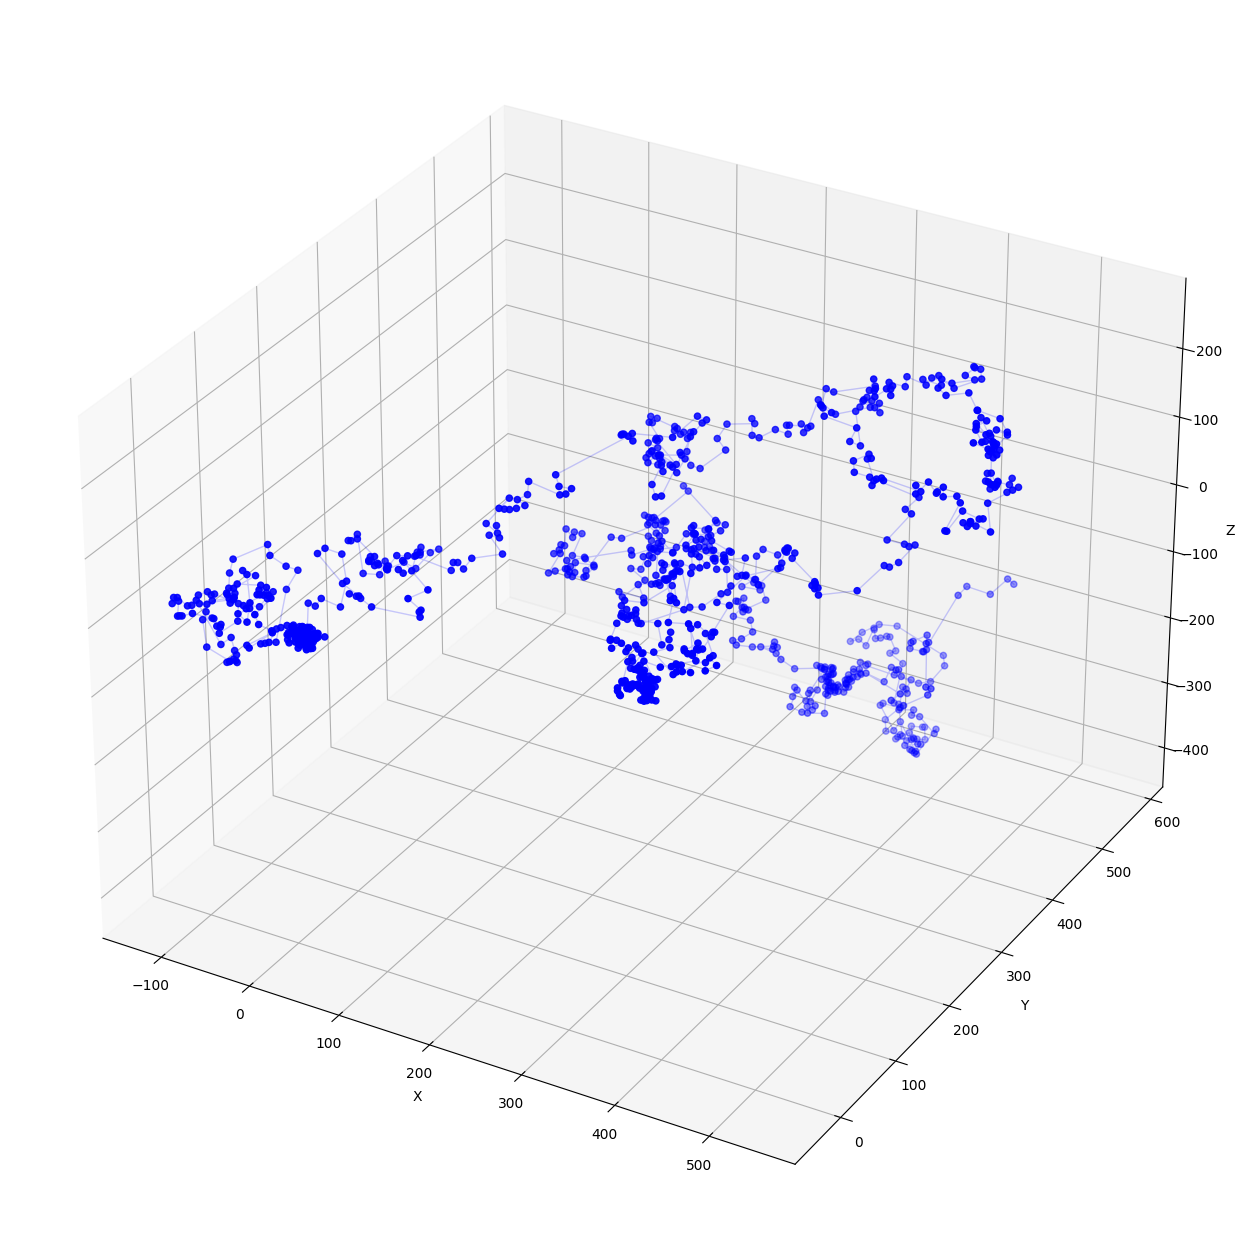

In [15]:
rn = all_rn[0]

fig = plt.figure(figsize=(20,16), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rn[:, 0], rn[:, 1], rn[:, 2], c='b', marker='o')
ax.plot(
    rn[:, 0], rn[:, 1], rn[:, 2], c='b', linestyle='-',
    linewidth=1, alpha=0.2
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### 5. Characterize Nucleosome Clusters.

##### Utility Functions

In [16]:
def identify_clusters(links):
    """Identify clusters from linker lengths.
    
    Note: Clusters are defined as four or more sequential
        nucleosomes where each subsequent nucleosome is
        separated from its neighbor by up to 15 bp.
        
    Parameters:
    links (np.ndarray) array of linker lengths
    
    Returns:
    clusters (Dict[int, List[int]]) Dictionary of nucleosome
        clusters, where keys provide a cluster index and values
        provide a list of nucleosomes associated with the
        cluster index.
    """
    clusters = {}
    cluster_ind = 0
    cluster_growing = True
    current_cluster = [0]
    
    for i in range(len(links)-1):
        if links[i] <= l_c:
            current_cluster.append(i+1)
        else:
            if len(current_cluster) >= 4:
                clusters[cluster_ind] = current_cluster
                cluster_ind += 1
            current_cluster = [i]

    return clusters


def compute_Rg(r):
    """Compute radius of gyration for a collection of points.
    
    Parameters:
    r (np.ndarray) Cartesian coordinates for a collection of
        points arranged in an N-by-3 array
    
    Returns:
    Rg (float) Radius of gyration for the points
    """
    center_of_mass = np.mean(r, axis=0)
    distances = np.linalg.norm(r - center_of_mass, axis=1)
    mean_square_distance = np.mean(distances**2)
    Rg = np.sqrt(mean_square_distance)
    return Rg


def compute_cluster_size(r):
    """Compute the size of a nucleosome cluster.
    
    Note: Cluster size is defined by twice the radius of
        gyration for the nucleosomes
        
    Parameters:
    r (np.ndarray) Cartesian coordinates for the nucleosomes
        in the cluster, arranged in an N-by-3 array
        
    Returns:
    cluster_size (float) Size of the nucleosome cluster
    """
    Rg = compute_Rg(r)
    cluster_size = 2 * Rg
    return cluster_size


def get_cluster_size_distribution(clusters, r_all):
    """Generate a list of cluster sizes.
    
    Parameters:
    clusters (Dict[int, List[int]]) Dictionary of nucleosome
        clusters, where keys provide a cluster index and values
        provide a list of nucleosomes associated with the
        cluster index.
    r_all (np.ndarray) Cartesian coordinates of all nucleosomes
        in the 3D chromatin configuration, arranged as an N-by-3
        array
        
    Returns:
    cluster_sizes (list of float) list of cluster sizes for all
        clusters
    """
    cluster_sizes = []
    for cluster in clusters.values():
        r = r_all[cluster]
        cluster_size = compute_cluster_size(r)
        cluster_sizes.append(cluster_size)
    return cluster_sizes

##### Application

In [17]:
cluster_sizes = []
clusters = identify_clusters(links)

for rn in all_rn:
    cluster_sizes += get_cluster_size_distribution(clusters, rn)

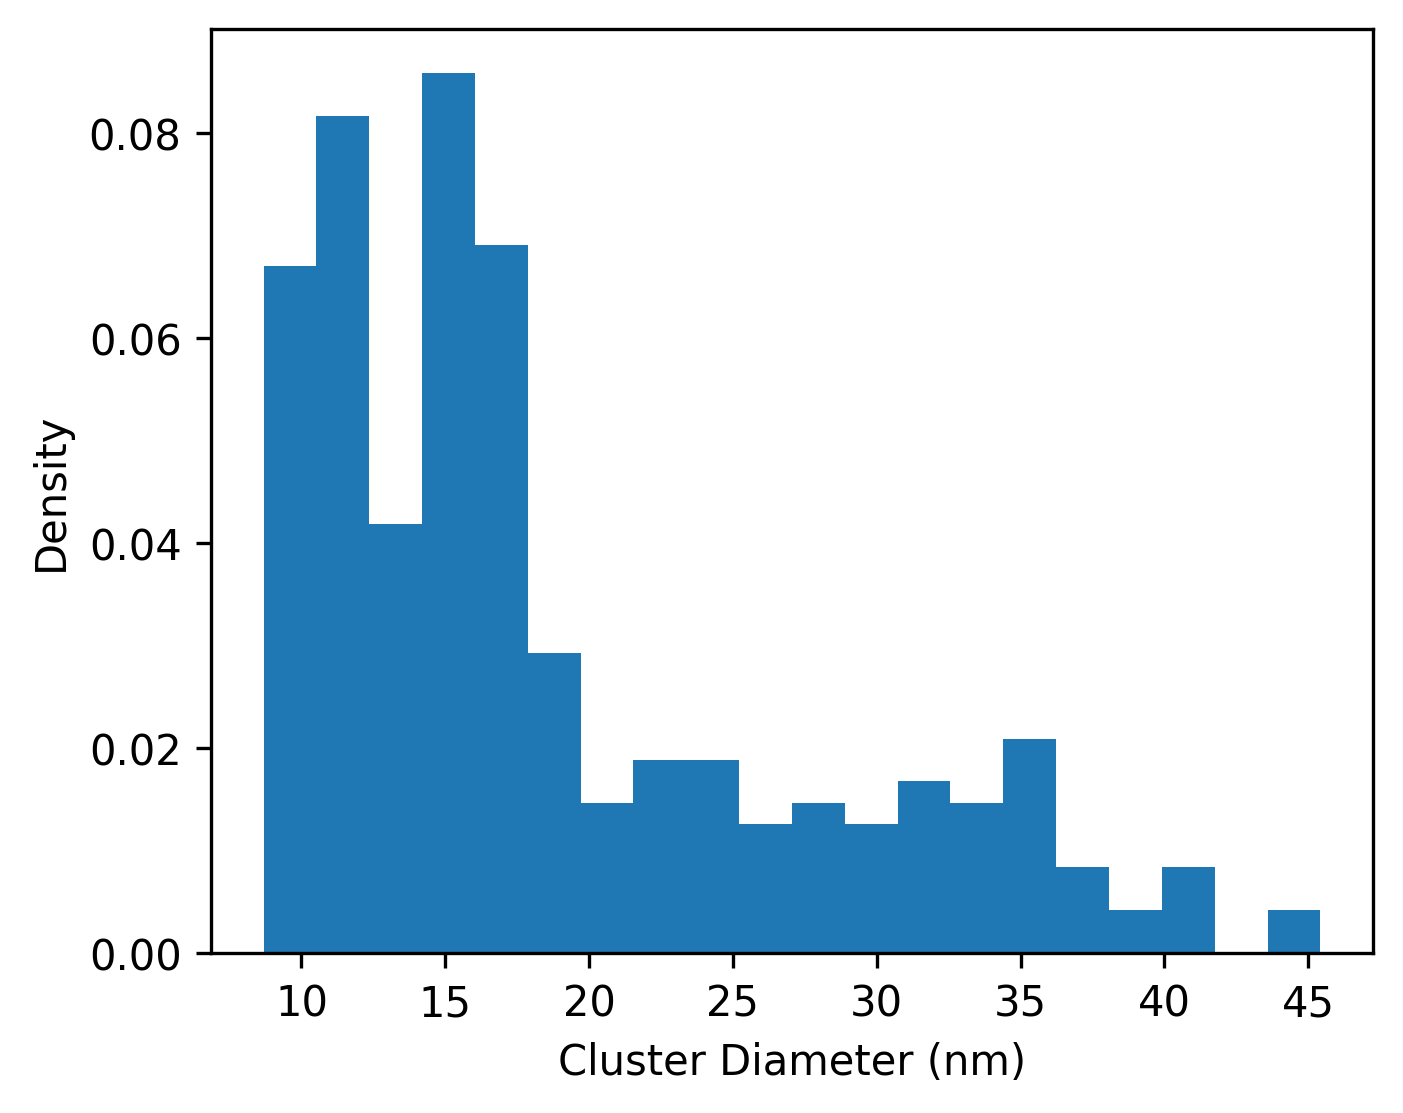

In [18]:
plt.figure(figsize=(5,4), dpi=300)
plt.hist(cluster_sizes, bins=20, density=True)
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Density")
plt.show()

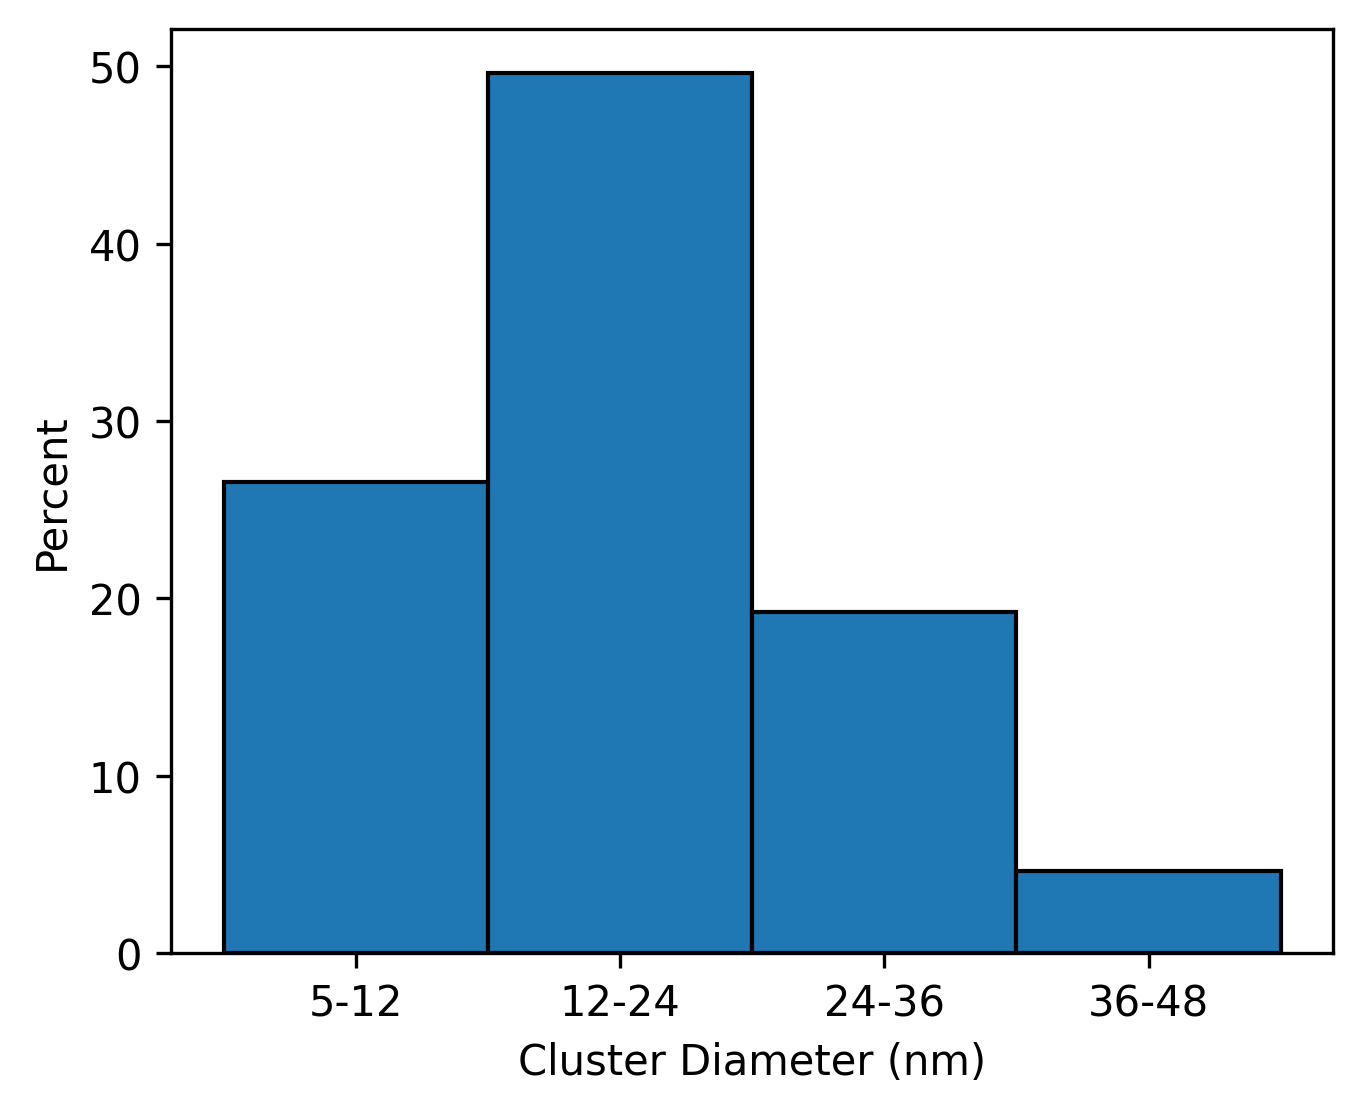

In [19]:
bins = [5, 12, 24, 36, 48]

plt.figure(figsize=(5,4), dpi=300)
hist, _ = np.histogram(cluster_sizes, bins=bins, density=False)
hist_percent = (hist / np.sum(hist)) * 100
bar_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
plt.bar(bar_labels, hist_percent, width=1, align='center', edgecolor="black")
plt.xlabel("Cluster Diameter (nm)")
plt.ylabel("Percent")
plt.show()